In [1]:
# use the dataloader to get all angles from label files and plot the distribution

In [2]:
import sys
import os, argparse
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import PIL
from pytz import timezone
from pathlib import Path
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.backends.cudnn as cudnn
import torchvision
import wandb

import datasets
# from utils import select_device, natural_keys, gazeto3d, angular, getArch
from utils import select_device, natural_keys, gazeto3d, angular, getArch
from model import L2CS
sys.path.append('/project/modules/jmodules')
from jutils import get_now

In [3]:
def parse_args():
    """Parse input arguments."""
    parser = argparse.ArgumentParser(description='Gaze estimation using L2CSNet')
#     # Gaze360
#     parser.add_argument(
#         '--gaze360image_dir', dest='gaze360image_dir', help='Directory path for gaze images.',
#         default='datasets/Gaze360/Image', type=str)
#     parser.add_argument(
#         '--gaze360label_dir', dest='gaze360label_dir', help='Directory path for gaze labels.',
#         default='datasets/Gaze360/Label/train.label', type=str)
#     # mpiigaze
    parser.add_argument(
        '--gazeMpiimage_dir', dest='gazeMpiimage_dir', help='Directory path for gaze images.',
        default='/project/data/Image', type=str)
    parser.add_argument(
        '--gazeMpiilabel_dir', dest='gazeMpiilabel_dir', help='Directory path for gaze labels.',
        default='/project/data/Label', type=str)

    # Important args -------------------------------------------------------------------------------------------------------
    # ----------------------------------------------------------------------------------------------------------------------
    parser.add_argument(
        '--dataset', dest='dataset', help='mpiigaze, rtgene, gaze360, ethgaze',
        default= "mpiigaze", type=str)
    parser.add_argument(
        '--output', dest='output', help='Path of output models.',
        default='/project/results/soutput3/snapshots/', type=str)
    parser.add_argument(
        '--snapshot', dest='snapshot', help='Path of model snapshot.',
        default='/project/results/soutput3/snapshots/', type=str)
    parser.add_argument(
        '--gpu', dest='gpu_id', help='GPU device id to use [0] or multiple 0,1,2,3',
        default='0', type=str)
    parser.add_argument(
        '--evalpath', dest='evalpath', help='path to save the evaluation results',
        default='/project/results/soutput3/evaluation/', type=str)
    parser.add_argument(
        '--num_epochs', dest='num_epochs', help='Maximum number of training epochs.',
        default=60, type=int)
    parser.add_argument(
        '--batch_size', dest='batch_size', help='Batch size.',
        default=200, type=int)
    parser.add_argument(
        '--arch', dest='arch', help='Network architecture, can be: ResNet18, ResNet34, [ResNet50], ''ResNet101, ResNet152, Squeezenet_1_0, Squeezenet_1_1, MobileNetV2',
        default='ResNet50', type=str)
    parser.add_argument(
        '--alpha', dest='alpha', help='Regression loss coefficient.',
        default=1, type=float)
    parser.add_argument(
        '--lr', dest='lr', help='Base learning rate.',
        default=0.00001, type=float)
    parser.add_argument(
        '--bins', dest='bins', help='number of angle bins',
        default=28, type=int)
    parser.add_argument(
        '--angle', dest='angle', help='angle limit',
        default=180, type=int)
    parser.add_argument(
        '--bin_width', dest='bin_width', help='width of anlge bins',
        default=4, type=int)
    
    # ---------------------------------------------------------------------------------------------------------------------
    # Important args ------------------------------------------------------------------------------------------------------
    args = parser.parse_args(['--angle', '180'])
    return args

In [4]:
args=parse_args()

In [5]:
# actually used
batch_size=args.batch_size
arch=args.arch
data_set=args.dataset
# evalpath =args.evalpath
snapshot_path = args.snapshot
bins=args.bins
angle=args.angle
bin_width=args.bin_width
gazeMpiimage_dir = args.gazeMpiimage_dir
gazeMpiilabel_dir=args.gazeMpiilabel_dir

In [6]:
# args = parse_args()
cudnn.enabled = True
gpu = select_device(args.gpu_id, batch_size=args.batch_size)
transformations = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
# #     transforms.Normalize(
# #         mean=[0.485, 0.456, 0.406],
# #         std=[0.229, 0.224, 0.225]
#     )
])
model_used= getArch(arch, bins)  #resnet50 and 28 bins

In [7]:
spath = Path(snapshot_path)
ckfiles =[]
for filename in sorted(spath.glob('*.pkl'), 
        key=lambda path: int(path.stem.rsplit("_", 1)[1])):
    ckfiles.append(filename)
print(f'number of checkpoint files: {len(ckfiles)}')

number of checkpoint files: 60


In [8]:
project = 'debug'

In [9]:
#labels
lfolder = os.listdir(gazeMpiilabel_dir)
lfolder.sort()  #individual label files
testlabelpathcombined = [os.path.join(gazeMpiilabel_dir, j) for j in lfolder]
gaze_dataset=datasets.Mpiigaze(testlabelpathcombined, gazeMpiimage_dir, transformations, False, angle, fold=-1)
# print(testlabelpathcombined)
test_loader = torch.utils.data.DataLoader(
            dataset=gaze_dataset,
            batch_size=batch_size,
            shuffle=True,
            num_workers=4,
            pin_memory=True)

# wandb.init(project=project, name='image_debug')
all_labels = None
for j, (images, labels, cont_labels, name) in enumerate(test_loader):
    mask = []
    cont_labels = cont_labels.numpy()
    # for real data: cont_labels[:,0] is yaw, cont_labels[:,1] is pitch
    for yaw, pitch in cont_labels:
        yaw = yaw*(-1)
        #condition yaw and pitch
        condp = abs(pitch+15)<0.2 or abs(pitch+10)<0.2 or abs(pitch+5)<0.2 or abs(pitch)<0.2
        condy = abs(yaw+15)<0.2 or abs(yaw+5)<0.2 or abs(yaw)<0.2 or abs(yaw-10)<0.2 or abs(yaw-15)<0.2
        if condp and condy:
            mask.append(True)
        else:
            mask.append(False)
    cont_labels = cont_labels[mask]
    images = images.numpy()
    images = images[mask]
    
    print(j, end =' ')
#     print(j, images.shape, cont_labels.shape)
#     print(cont_labels.shape, type(cont_labels.numpy()))
    if cont_labels.shape[0] == 0:
        continue
    if all_labels is None:
        all_labels = cont_labels
        all_images = images
    else:
        all_labels = np.concatenate((all_labels, cont_labels), axis=0)
        all_images = np.concatenate((all_images, images), axis=0)

path is a list, len(path): 15
0 items removed from dataset that have an angle > 180
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 

In [10]:
all_labels.shape, all_images.shape

((192, 2), (192, 3, 224, 224))

In [11]:
pitches = all_labels[:,1]
yaws = all_labels[:,0]*(-1.0)

In [12]:
print(len(pitches), len(yaws), len(all_images))

192 192 192


In [13]:
np.set_printoptions(precision=1, suppress=True)
print(all_labels[0:5])

[[-10.  -15.1]
 [  0.2 -15. ]
 [-10.1 -10. ]
 [ -0.  -14.9]
 [  0.2  -9.8]]


In [14]:
def stamp_images(images, labels):
    """images arew assumed to be a numpy array converted directly from torch
    like images = images.numpy(), it will have shape (N, C, H, W)"""
    stamped=[]
    images = np.uint8(images*255)
    images = np.moveaxis(images, 1, 3)
    pimages = [PIL.Image.fromarray(im) for im in images]
    for img, label in zip(pimages, labels):
        draw = PIL.ImageDraw.Draw(img)
        # font = ImageFont.truetype(<font-file>, <font-size>)
        
        ft = "/usr/lib/code-server/node_modules/pem/docs/docco/public/fonts/aller-bold.ttf"
        font = PIL.ImageFont.truetype(ft, 20)
        # draw.text((x, y),"Sample Text",(r,g,b))
        
        text1 = f'pitch:{label[1]:.1f}'
        text2 = f'yaw  :{label[0]*(-1.0):.1f}'
        draw.text((10, 190),text1, (255,255,255),font=font)
        draw.text((10, 170),text2, (255,255,255),font=font)
        stamped.append(img)
    return stamped

In [15]:
stamped = stamp_images(all_images[0:40], all_labels[0:40])

In [16]:
with wandb.init(project=project, name="rdata_stamped_images_nyaw_pitch")as run:
    run.log({"stamped_rdata_nyaw_pitch": [wandb.Image(img) for img in stamped] })

wandb: Currently logged in as: synthesis-ai (use `wandb login --relogin` to force relogin)


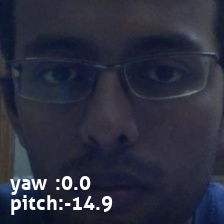

In [17]:
display(stamped[3])

In [18]:
cimages = np.uint8(all_images*255)
cimages = np.moveaxis(cimages, 1,3)
pimages = [PIL.Image.fromarray(im) for im in cimages]